### compare v1.5, v1.7

In [114]:
pwd

'/home/idies/workspace/Storage/lixl/persistent/LSSTunknowns/tdAnom'

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"

#plt.rcParams['axes.labelsize'] = 16
#plt.rcParams['axes.titlesize'] = 16



In [4]:
# load opsim database
dbpath_v1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v1_7 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"  # path to all opsim databases


# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
#resultsDb = db.ResultsDb(outDir=outDir)



In [5]:
# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath_v1_5)  # change to opsim database directory
dblist_all_v1_5 = glob.glob('*.db') 
dblist_all_v1_5.sort()

os.chdir(dbpath_v1_7)  # change to opsim database directory
dblist_all_v1_7 = glob.glob('*.db') 
dblist_all_v1_7.sort()

os.chdir(workpath) # change back to work directory



In [7]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [52]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("10yrs", "") )

    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new




In [9]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [137]:
def plot_barh_v2(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""
    from matplotlib.patches import Patch

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    #plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    #for i, patch in enumerate(ax.patches):
    #    if i in [10,20]:
    #        patch.set_color('black')
    
    # modify labels
    #for tl in ax.get_yticklabels():
    #    txt = tl.get_text()
    #    if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_backgroundcolor("#E5E7E9")
    #    if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_fontweight('bold') 
            
    #    #tl.set_text(txt)
    #cmap = plt.cm.get_cmap('plasma')
    #colors = [cmap(i) for i in np.linspace(0, 1, 4)][:4]
    colors = [(0.050383, 0.029803, 0.527975, 0.65),
              (0.610667, 0.090204, 0.619951, 0.65),
              ( 0.928329, 0.472975, 0.326067, 0.65),
              (0.940015, 0.975158, 0.131326, 0.65)]
    
    color1 = 'steelblue'
    color2 = colors[2]
    for i, (patch, tl) in enumerate( zip(ax.patches[:160], ax.get_yticklabels() ) ):
        txt = tl.get_text()
        for pi in [i+160*j for j in range(5)]:
            p = ax.patches[pi]
            if 'v1.7' in txt:
                p.set_color(color1)   
            else:
                p.set_color(color2)
                
            p.set_linewidth(0.1)
            p.set_edgecolor('black')
                        
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    # create legend
    legend_elements = [ Patch(facecolor=color1, edgecolor='k',
                         label='OpSim v1.7'),
                        Patch(facecolor=color2, edgecolor='k',
                         label='OpSim v1.5')]
              
    ax.legend(handles=legend_elements, loc='lower right', facecolor='w', frameon=True)

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    
    return ax


### prepare concat df_radar

In [47]:
# for proposalId=1 wfd

#df_tgaps_v1_5 = pd.read_csv('./data_v1_5/df_tgapsFoM_wfd.csv')
#df_nfields_v1_5 = pd.read_csv('./data_v1_5/df_Nfields_wfd_2d.csv')
#df_nstars_v1_5 = pd.read_csv('./data_v1_5/df_Nstars_wfd_2d.csv')
#df_depth_v1_5 = pd.read_csv('./data_v1_5/df_depth_wfd.csv')

#df_tgaps_v1_7 = pd.read_csv('./data_v1_7/df_tgapsFoM_wfd.csv')
#df_nfields_v1_7 = pd.read_csv('./data_v1_7/df_Nfields_wfd_2d.csv')
#df_nstars_v1_7 = pd.read_csv('./data_v1_7/df_Nstars_wfd_2d.csv')
#df_depth_v1_7 = pd.read_csv('./data_v1_7/df_depth_wfd.csv')

# for all

#df_tgaps_v1_5 = pd.read_csv('./data_v1_5/df_tgapsFoM_all_noddf.csv')
#df_nfields_v1_5 = pd.read_csv('./data_v1_5/df_Nfields_all_2d.csv')
#df_nstars_v1_5 = pd.read_csv('./data_v1_5/df_Nstars_all_2d.csv')
#df_depth_v1_5 = pd.read_csv('./data_v1_5/df_depth_all.csv')
#
#df_tgaps_v1_7 = pd.read_csv('./data_v1_7/df_tgapsFoM_all_noddf.csv')
#df_nfields_v1_7 = pd.read_csv('./data_v1_7/df_Nfields_all_2d.csv')
#df_nstars_v1_7 = pd.read_csv('./data_v1_7/df_Nstars_all_2d.csv')
#df_depth_v1_7 = pd.read_csv('./data_v1_7/df_depth_all.csv')




In [127]:
# reduce for v1.5 number of visits by 0.07 

# for proposalId=1 wfd
#df_tgaps_v1_5 = pd.read_csv('./data_v1_5/df_tgapsFoM_wfd_reduced.csv')
#df_nfields_v1_5 = pd.read_csv('./data_v1_5/df_Nfields_wfd_2d_reduced.csv')
#df_nstars_v1_5 = pd.read_csv('./data_v1_5/df_Nstars_wfd_2d_reduced.csv')
#df_depth_v1_5 = pd.read_csv('./data_v1_5/df_depth_wfd.csv')
#
#df_tgaps_v1_7 = pd.read_csv('./data_v1_7/df_tgapsFoM_wfd.csv')
#df_nfields_v1_7 = pd.read_csv('./data_v1_7/df_Nfields_wfd_2d.csv')
#df_nstars_v1_7 = pd.read_csv('./data_v1_7/df_Nstars_wfd_2d.csv')
#df_depth_v1_7 = pd.read_csv('./data_v1_7/df_depth_wfd.csv')

# for all

df_tgaps_v1_5 = pd.read_csv('./data_v1_5/df_tgapsFoM_all_reduced.csv')
df_nfields_v1_5 = pd.read_csv('./data_v1_5/df_Nfields_all_2d_reduced.csv')
df_nstars_v1_5 = pd.read_csv('./data_v1_5/df_Nstars_all_2d_reduced.csv')
df_depth_v1_5 = pd.read_csv('./data_v1_5/df_depth_all.csv')

df_tgaps_v1_7 = pd.read_csv('./data_v1_7/df_tgapsFoM_all_noddf.csv')
df_nfields_v1_7 = pd.read_csv('./data_v1_7/df_Nfields_all_2d.csv')
df_nstars_v1_7 = pd.read_csv('./data_v1_7/df_Nstars_all_2d.csv')
df_depth_v1_7 = pd.read_csv('./data_v1_7/df_depth_all.csv')



In [24]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']



In [20]:

def df_concat( df_v1_5, df_v1_7 ):

    df_v1_5['db'] = dblist_all_v1_5
    df_v1_5['version'] = 'v1_5'

    df_v1_7['db'] = dblist_all_v1_7
    df_v1_7['version'] = 'v1_7'
    
    df = pd.concat([df_v1_5, df_v1_7])
    
    return df


In [128]:
df_tgaps = df_concat(df_tgaps_v1_5, df_tgaps_v1_7)
df_nfields = df_concat(df_nfields_v1_5, df_nfields_v1_7)
df_nstars = df_concat(df_nstars_v1_5, df_nstars_v1_7)
df_depth = df_concat(df_depth_v1_5, df_depth_v1_7)

In [129]:
# normalize
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_tgaps[col] = scale(df_tgaps[col], mode=0)
    df_nfields[col] = scale(df_nfields[col], mode=2, fmax=1460)
    df_nstars[col] = scale(df_nstars[col], mode=2, fmax=122876537)

for col in filters:
    df_depth[col] = scale(df_depth[col], mode=1)

df_tgaps['total_same'] = scale( np.sum(df_tgaps[ cols_same ], axis=1) )
df_tgaps['total_diff'] = scale( np.sum(df_tgaps[ cols_diff ], axis=1) )
df_nfields['total'] = scale( np.sum(df_nfields[ cols_all ], axis=1) )
df_nstars['total'] = scale( np.sum(df_nstars[ cols_all ], axis=1) )
df_depth['total'] = scale( np.sum(df_depth[ filters ], axis=1) )



In [130]:
#msname = 'wfd_v1_5_v1_7'
#msname = 'all_v1_5_v1_7'
msname = 'all_v1_5_v1_7_reduced'

df_radar = pd.DataFrame()
df_radar['db'] = df_nfields['db']

df_radar['brightness'] = df_tgaps['total_same']
df_radar['color'] = df_tgaps['total_diff'] 

df_radar['footprint'] = df_nfields['total']
df_radar['star density'] = df_nstars['total']
df_radar['depth'] = df_depth['total']
df_radar['family'] = df_radar.apply(get_family, axis=1)

# save file 
df_radar.to_csv('./data_v1_5/df_radar_{}.csv'.format(msname), index=False)

In [34]:
df_radar

,db,brightness,color,footprint,star density,depth,family
0,agnddf_v1.5_10yrs.db,0.132988,0.527501,0.717233,0.728116,0.932316,agnddf
1,alt_dust_v1.5_10yrs.db,0.133044,0.713457,0.442079,0.254255,0.802599,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,0.138956,0.815314,0.551082,0.306606,0.695747,alt
3,baseline_2snaps_v1.5_10yrs.db,0.135375,0.488204,0.437133,0.467183,0.864364,baseline
4,baseline_samefilt_v1.5_10yrs.db,0.206479,0.168159,0.519281,0.504146,0.867671,baseline
5,baseline_v1.5_10yrs.db,0.142425,0.570226,0.752009,0.766289,0.923285,baseline
6,bulges_bs_v1.5_10yrs.db,0.122704,0.418788,0.325309,0.268242,0.927775,bulges
7,bulges_bulge_wfd_v1.5_10yrs.db,0.126914,0.414171,0.309274,0.241618,0.930381,bulges
8,bulges_cadence_bs_v1.5_10yrs.db,0.130511,0.427812,0.327589,0.263078,0.924143,bulges
9,bulges_cadence_bulge_wfd_v1.5_10yrs.db,0.130241,0.414580,0.306955,0.242100,0.925624,bulges


In [35]:
FoMvars = ['brightness','color', 'depth', 'footprint', 'star density',]




In [36]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



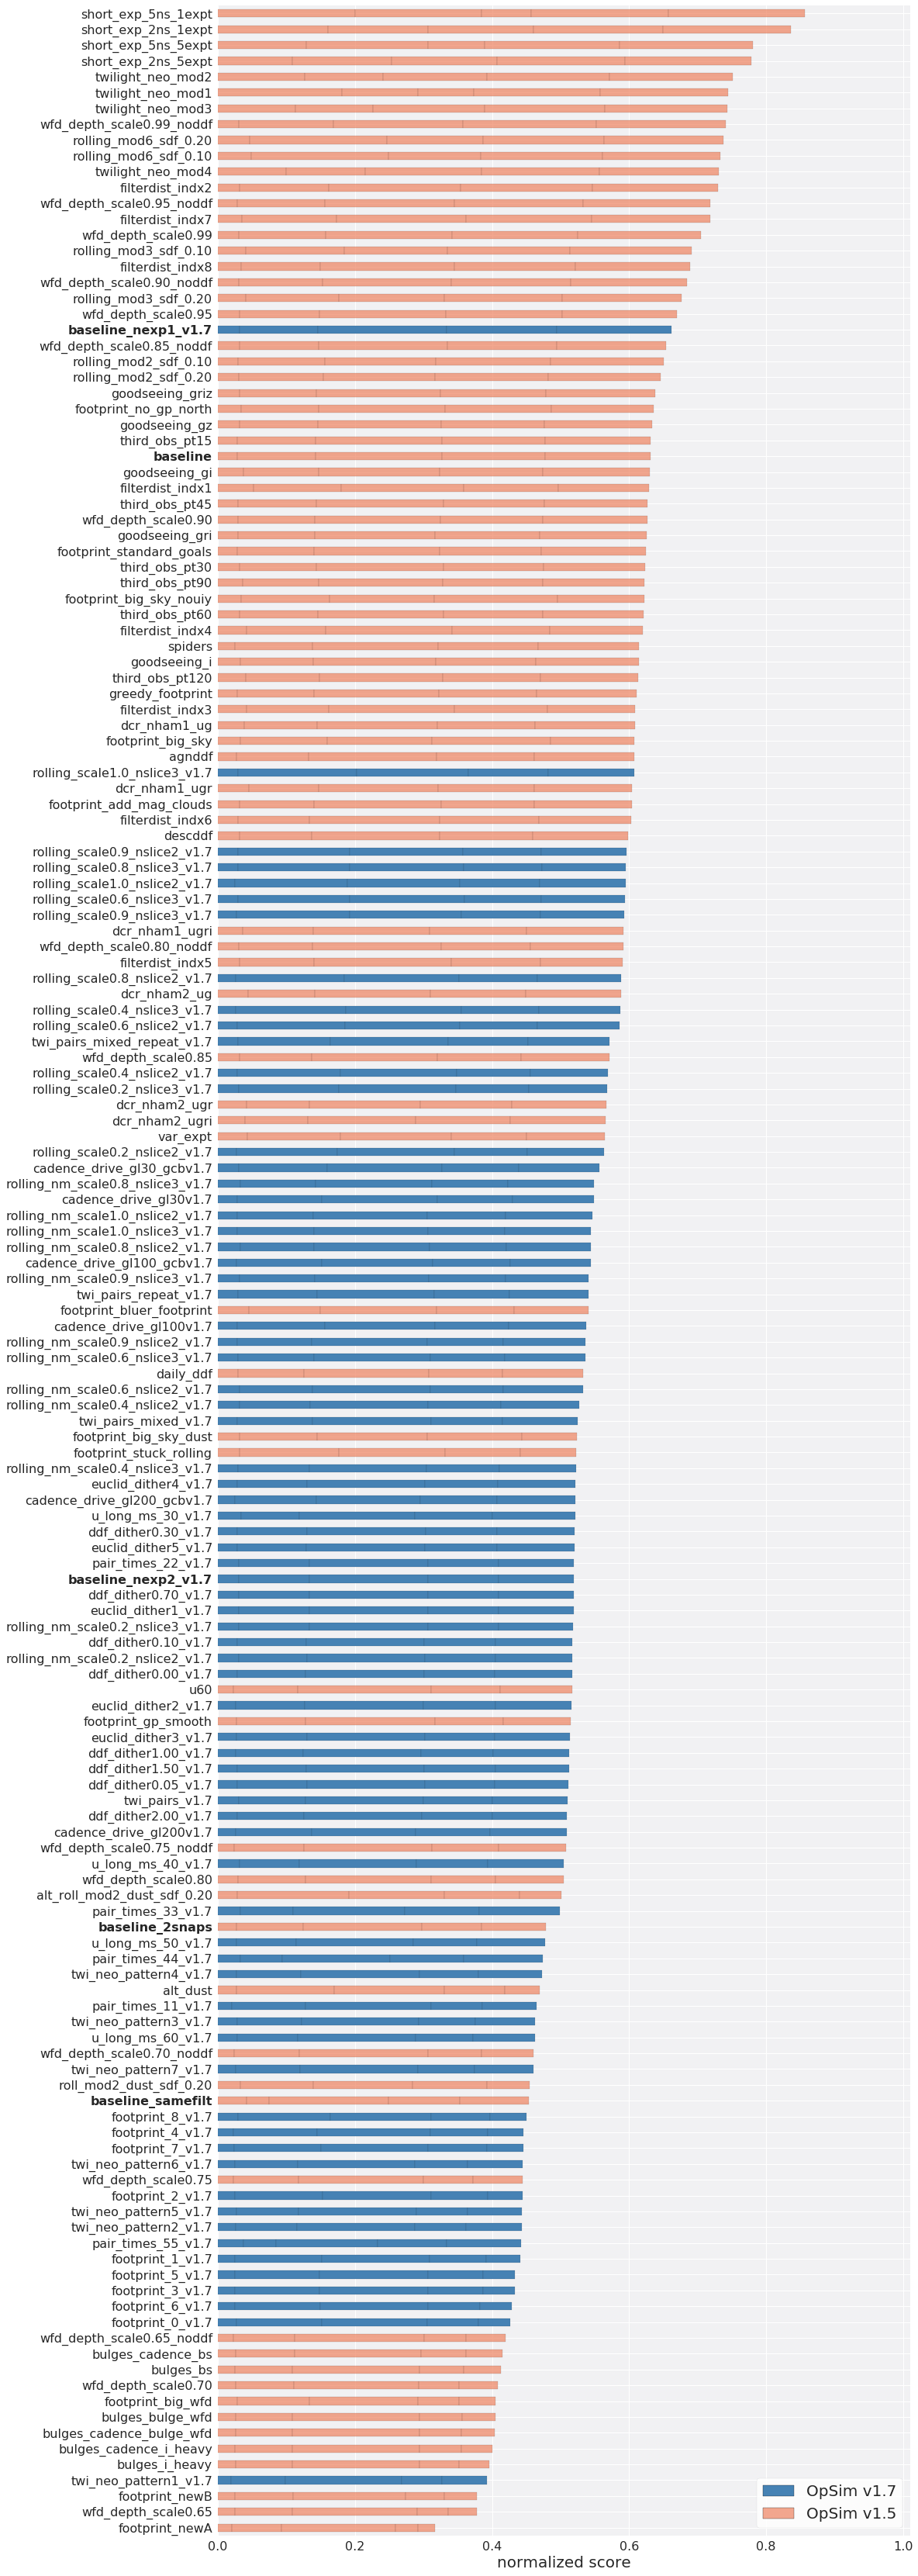

In [133]:
fomcsv = './data_v1_5/df_radar_wfd_v1_5_v1_7.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v2(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_wfd_v1_5_v1_7.pdf', colormap=mymap ) 




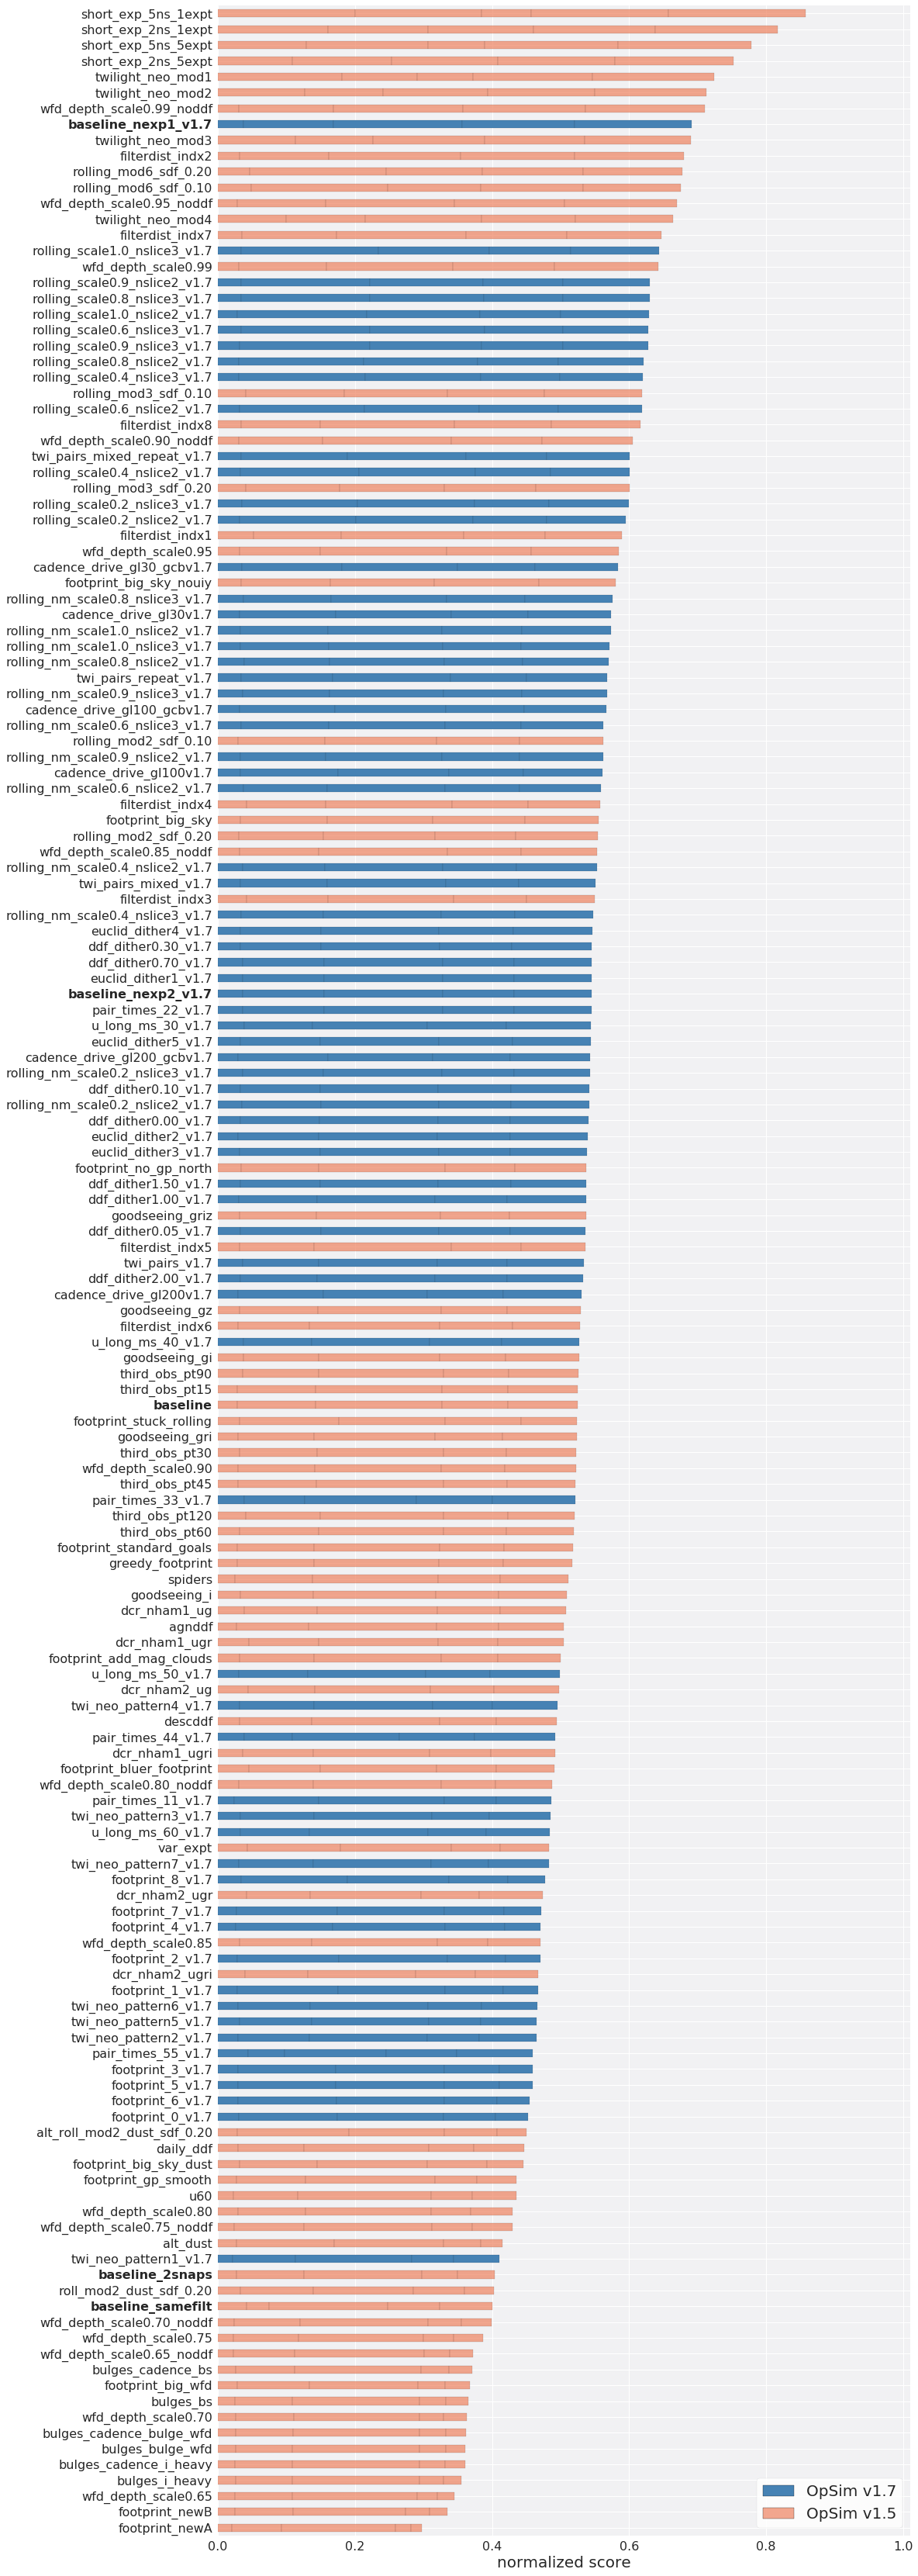

In [134]:
fomcsv = './data_v1_5/df_radar_wfd_v1_5_v1_7_reduced.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v2(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_wfd_v1_5_v1_7_reduced.pdf', colormap=mymap ) 




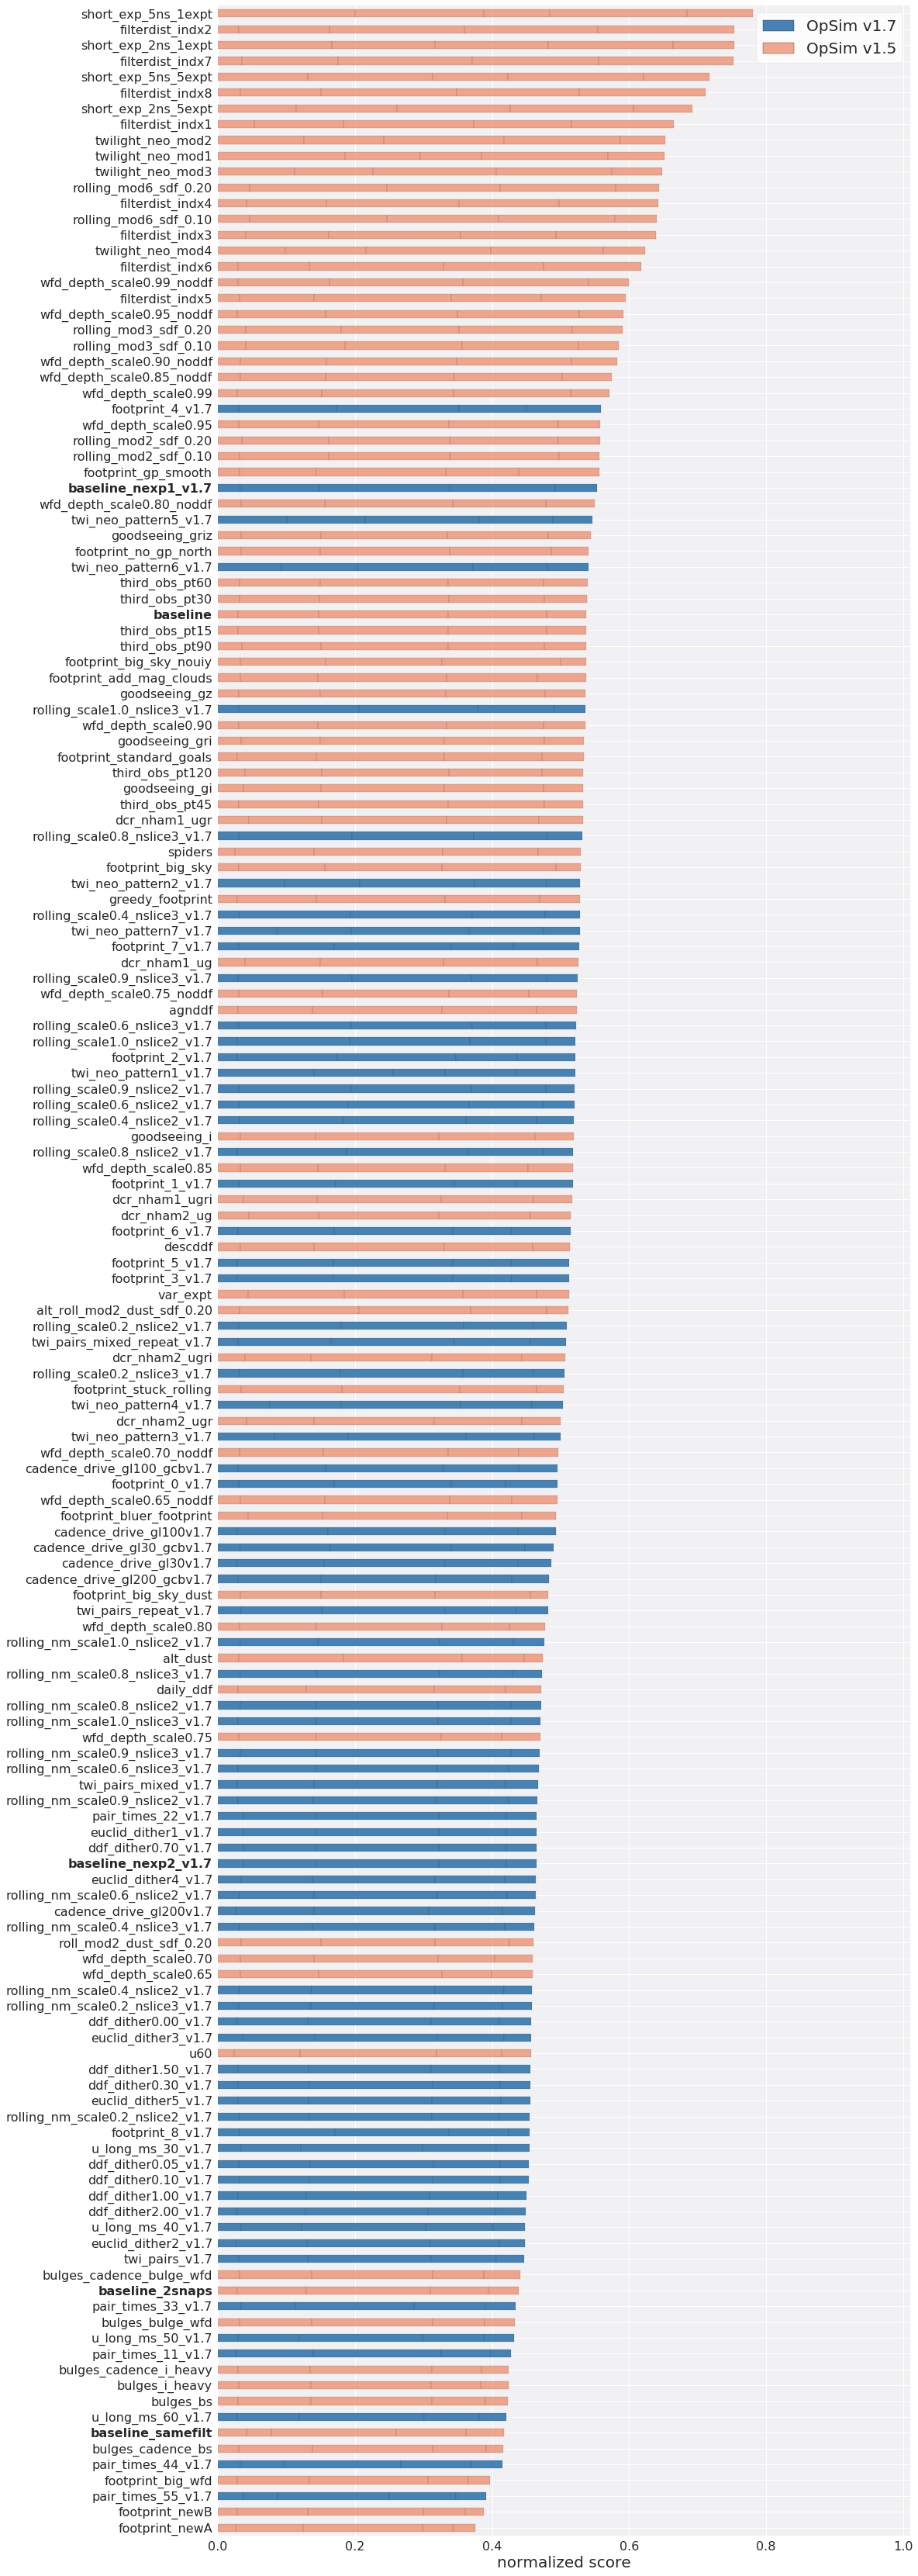

In [135]:
fomcsv = './data_v1_5/df_radar_all_v1_5_v1_7.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v2(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7.pdf', colormap=mymap ) 



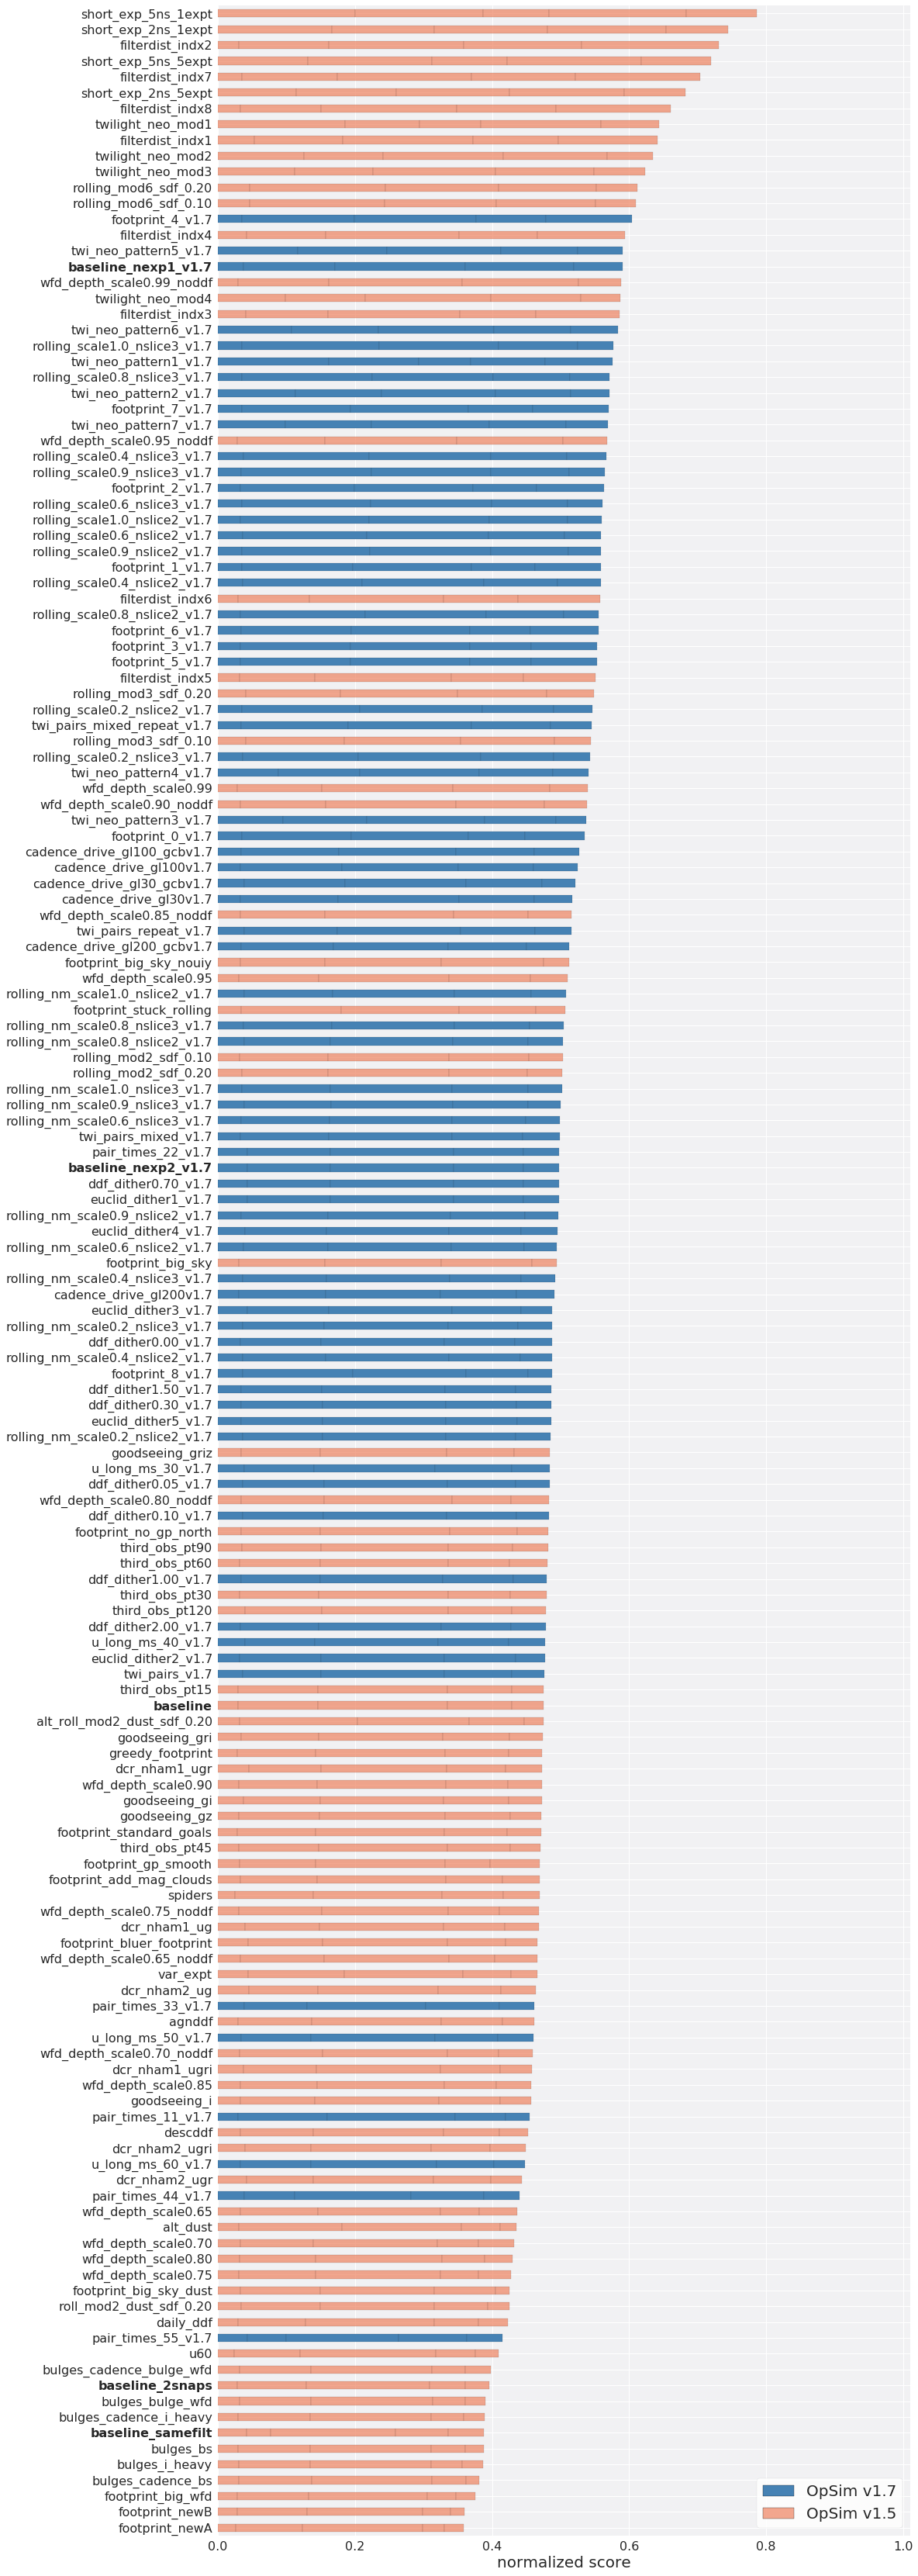

In [136]:
fomcsv = './data_v1_5/df_radar_all_v1_5_v1_7_reduced.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v2(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7_reduced.pdf', colormap=mymap ) 


